In [3]:
! pip install tensorflow_gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 4.3MB 36.0MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 501kB 36.6MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

# 01.합성곱

넘파이 합성곱

In [ ]:
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

#배열 뒤집기
#1
w_r = np.flip(w)
#2
w_r = w[::-1]

#스트라이드 및 합성곱
for i in range(6):
  print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


싸이파이 합성곱

In [ ]:
#싸이파이를 이용한 합성곱
from scipy.signal import convolve
convolve(x, w, mode = 'valid')

array([63, 48, 49, 28, 21, 20])

In [ ]:
#싸이파이를 이용한 교차 상관
from scipy.signal import correlate
correlate(x, w, mode = 'valid')

array([48, 57, 24, 25, 16, 39])

In [ ]:
#풀 패딩
correlate(x, w, mode = 'full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [ ]:
#세임 패딩
correlate(x, w, mode = 'same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

2차원 배열의 합성곱

In [ ]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode = 'valid')

array([[ 2,  4],
       [ 8, 10]])

In [ ]:
#2차원 세임 패딩
correlate2d(x, w, mode = 'same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

4차원 배열의 합성곱

In [ ]:
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)
c_out = tf.nn.conv2d(x_4d, w_4d, strides = 1, padding = 'SAME')
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

# 02.풀링 연산

최대 풀링, 평균 풀링

In [ ]:
 x = np.array([[1, 2, 3, 4],
               [5, 6, 7, 8],
               [9, 10, 11, 12],
               [13, 14, 15, 16]])
 x = x.reshape(1, 4, 4, 1)
 p_out = tf.nn.max_pool2d(x, ksize = 2, strides = 2, padding = 'VALID')
#  평균 풀링 : avg_pool2d()
p_out.numpy().reshape(2, 2)

array([[ 6,  8],
       [14, 16]])

# 03.합성곱 신경망의 구조

렐루 함수

In [ ]:
# maximum() 함수를 이용한 렐루함수
def relu(x):
  return np.maximum(x, 0)

In [ ]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

In [ ]:
#텐서플로를 이용한 렐루 함수
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 04.합성곱 신경망 제작 및 훈련

합성곱 신경망 모듈

In [5]:
class ConvolutionNetwork:

  def __init__(self, n_kernels = 10, units = 10, batch_size = 32, learning_rate = 0.1):
    self.n_kernels = n_kernels        # 합성곱의 커널 개수
    self.kernel_size = 3              # 커널 크기
    self.optimizer = None             # 옵티마이저
    self.conv_w = None                # 합성곱층의 가중치
    self.conv_b = None                # 합성곱층의 절편
    self.units = units                # 은닉층의 뉴런 개수
    self.batch_size = batch_size      # 배치 크기
    self.w1 = None                    # 은닉층의 가중치
    self.b1 = None                    # 은닉층의 절편
    self.w2 = None                    # 출력층의 가중치
    self.b2 = None                    # 출력층의 절편
    self.a1 = None                    # 은닉층의 활성화 출력
    self.losses = []                  # 훈련 손실
    self.val_losses = []              # 검증 손실
    self.lr = learning_rate           # 학습률

  def forpass(self, x):
    # 3×3 합성곱 연산을 수행
    c_out = tf.nn.conv2d(x, self.conv_w, strides = 1, padding = 'SAME') + self.conv_b
    # 렐루 활성화 함수 적용
    r_out = tf.nn.relu(c_out)
    # 2×2 최대 풀링 적용
    p_out = tf.nn.max_pool2d(r_out, ksize = 2, strides = 2, padding = 'VALID')
    # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼침
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1        # 첫 번째 층의 선형식 계산
    a1 = tf.nn.relu(z1)                             # 활성화 함수 적용
    z2 = tf.matmul(a1, self.w2) + self.b2           # 두 번째 층의 선형식을 계산
    return z2

  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype = float)
    n_features = 14 * 14 * self.n_kernels
    self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층 크기)
    self.b1 = tf.Variable(np.zeros(self.units), dtype = float)  # 은닉층 크기
    self.w2 = tf.Variable(g((self.units, n_classes)))          # (은닉층 크기, 클래스 개수)
    self.b2 = tf.Variable(np.zeros(n_classes), dtype = float)    # 클래스 개수

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    self.init_weights(x.shape, y.shape[1])             # 은닉층과 출력층의 가중치를 초기화
    self.optimizer = tf.optimizers.SGD(learning_rate = self.lr)
    # 에포크 만큼 반복
    for i in range(epochs):
      print('에포크', i, end = '')
      # 제너레이터 함수에서 반환한 미니 배치를 순환
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end = '')
        self.training(x_batch, y_batch)
        # 배치 손실을 기록
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print()
      # 배치 손실 평균을 내어 훈련 손실값으로 저장
      self.losses.append(np.mean(batch_losses))
      # 검증 세트에 대한 손실을 계산
      self.val_losses.append(self.get_loss(x_val, y_val))

  #미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size                    # 미니 배치 횟수
    indexes = np.random.permutation(np.arange(len(x)))  # 인덱스 셔플
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start:end], y[start:end]     # batch_size만큼 슬라이싱하여 반복

  def training(self, x, y):
    m = len(x)                            # 샘플 개수를 저장
    with tf.GradientTape() as tape:
      z = self.forpass(x)                 # 정방향 계산을 수행
      # 손실을 계산
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
    # 가중치에 대한 그레이디언트를 계산
    grads = tape.gradient(loss, weights_list)
    # 가중치 업데이트
    self.optimizer.apply_gradients(zip(grads, weights_list))

  def predict(self, x):
    z = self.forpass(x)                     # 정방향 계산 수행
    return np.argmax(z.numpy(), axis = 1)   # 가장 큰 값의 인덱스 반환

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
    return np.mean(self.predict(x) == np.argmax(y, axis = 1))

  def get_loss(self, x, y):
    z = self.forpass(x)                     # 정방향 계산 수행
    # 손실을 계산하여 저장
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

모듈 훈련

In [6]:
# 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
# 훈련 데이터 세트 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [8]:
# 타깃을 원-핫 인코딩으로 변환하기
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [9]:
# 입력 데이터 준비
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train.shape

(48000, 28, 28, 1)

In [10]:
# 입력 데이터 표준화 전처리
x_train = x_train / 255
x_val = x_val / 255

In [ ]:
#  모델 훈련
cn = ConvolutionNetwork(n_kernels = 10, units = 100, batch_size = 128, learning_rate = 0.01)
cn.fit(x_train, y_train_encoded, x_val = x_val, y_val = y_val_encoded, epochs = 30)

에포크 0.......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1.......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2.........................................................................................................................................................................................................................................

<function matplotlib.pyplot.show>

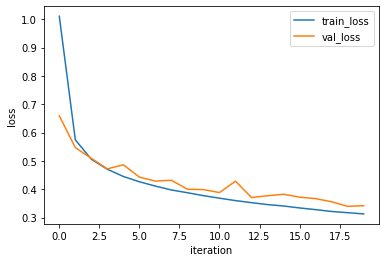

In [12]:
# 검증 손실 그래프, 검증세트의 정확도 확인

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show

In [13]:
cn.score(x_val, y_val_encoded)

0.88125

# 05.케라스 합성곱 신경망 제작

케라스 합성곱 신경망 모듈 제작

In [ ]:
# 클래스 임포트
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# 합성곱층 쌓기
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))

# 폴링층 쌓기
conv1.add(MaxPooling2D((2, 2)))

# 완전 연결층에 주입할 수 있도록 특성 맵 펼치기
conv1.add(Flatten())

# 완전 연결층 쌓기
conv1.add(Dense(100, activation = 'relu'))
conv1.add(Dense(10, activation = 'softmax'))

In [ ]:
conv1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


합성곱 신경망 모듈 훈련하기

In [ ]:
# 크로스 엔트로피 손실 함수 전달
conv1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 아담 옵티마이저(최적화 함수)를 사용한 훈련
history = conv1.fit(x_train, y_train_encoded, epochs = 20, validation_data = (x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 26s 535us/sample - loss: 0.4463 - accuracy: 0.8418 - val_loss: 0.3262 - val_accuracy: 0.8841
Epoch 2/20
48000/48000 [==============================] - 25s 513us/sample - loss: 0.3085 - accuracy: 0.8896 - val_loss: 0.2877 - val_accuracy: 0.8963
Epoch 3/20
48000/48000 [==============================] - 25s 511us/sample - loss: 0.2666 - accuracy: 0.9022 - val_loss: 0.2818 - val_accuracy: 0.8988
Epoch 4/20
48000/48000 [==============================] - 25s 516us/sample - loss: 0.2392 - accuracy: 0.9118 - val_loss: 0.2550 - val_accuracy: 0.9085
Epoch 5/20
48000/48000 [==============================] - 25s 526us/sample - loss: 0.2146 - accuracy: 0.9219 - val_loss: 0.2647 - val_accuracy: 0.9076
Epoch 6/20
48000/48000 [==============================] - 25s 528us/sample - loss: 0.1927 - accuracy: 0.9293 - val_loss: 0.2583 - val_accuracy: 0.9086
Epoch 7/20
48000/48000 [====================

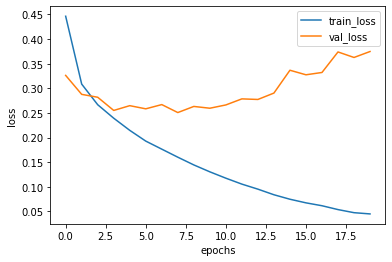

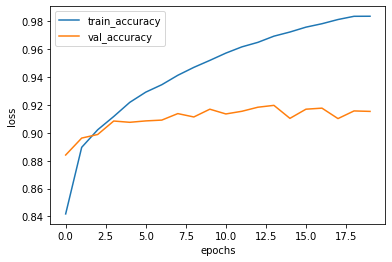

In [ ]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

드롭아웃 적용

In [ ]:
from tensorflow.keras.layers import Dropout

# 합성곱층 쌓기
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))

# 폴링층 쌓기
conv2.add(MaxPooling2D((2, 2)))

# 완전 연결층에 주입할 수 있도록 특성 맵 펼치기
conv2.add(Flatten())

# 드롭아웃층 추가
conv2.add(Dropout(0.5))

# 완전 연결층 쌓기
conv2.add(Dense(100, activation = 'relu'))
conv2.add(Dense(10, activation = 'softmax'))

In [ ]:
# 드롭아웃층 확인
conv2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [ ]:
# 크로스 엔트로피 손실 함수 전달
conv2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# 아담 옵티마이저(최적화 함수)를 사용한 훈련
history = conv2.fit(x_train, y_train_encoded, epochs = 20, validation_data = (x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 26s 543us/sample - loss: 0.4934 - accuracy: 0.8238 - val_loss: 0.3534 - val_accuracy: 0.8755
Epoch 2/20
48000/48000 [==============================] - 25s 520us/sample - loss: 0.3636 - accuracy: 0.8676 - val_loss: 0.2988 - val_accuracy: 0.8948
Epoch 3/20
48000/48000 [==============================] - 25s 524us/sample - loss: 0.3282 - accuracy: 0.8793 - val_loss: 0.2822 - val_accuracy: 0.8992
Epoch 4/20
48000/48000 [==============================] - 25s 525us/sample - loss: 0.3005 - accuracy: 0.8876 - val_loss: 0.2700 - val_accuracy: 0.9023
Epoch 5/20
48000/48000 [==============================] - 25s 527us/sample - loss: 0.2850 - accuracy: 0.8927 - val_loss: 0.2581 - val_accuracy: 0.9064
Epoch 6/20
48000/48000 [==============================] - 26s 540us/sample - loss: 0.2711 - accuracy: 0.9000 - val_loss: 0.2480 - val_accuracy: 0.9084
Epoch 7/20
48000/48000 [====================

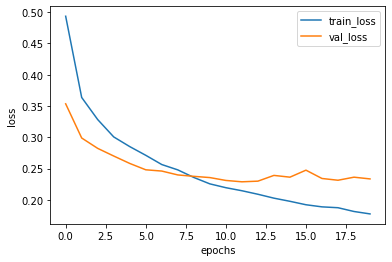

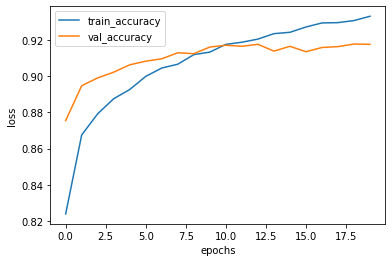

In [ ]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()